In [71]:
from model.frame import Framework
from data.slice import get_tiff_np, read_shp, read_tiff, get_mask
import model.functions as fn
from model.metrics import *
def get_tp_fp_fn(pred, true):
    pred, true = torch.from_numpy(pred), torch.from_numpy(true)
    tp, fp, fn = tp_fp_fn(pred, true)
    return tp, fp, fn

def get_precision_recall_iou(tp, fp, fn):
    p, r, i = precision(tp, fp, fn), recall(tp, fp, fn), IoU(tp, fp, fn)
    return p, r, i

import yaml
import pathlib
import rasterio
import rasterio.plot
import torch
import pdb
from addict import Dict
import numpy as np
import pandas as pd
from skimage.color import rgb2hsv
import matplotlib.pyplot as plt
from scipy.ndimage.morphology import binary_fill_holes
from PIL import Image
from tqdm import tqdm

import seaborn_image as isns

In [15]:
conf = Dict(yaml.safe_load(open('./conf/predict_slices.yaml')))

#% Prediction-specific config
runs_dir = pathlib.Path(conf.runs_dir)
output_dir = pathlib.Path(conf.output_dir)

#% Load checkpoint using the training config
checkpoint_path = runs_dir / conf.run_name / 'models' / 'model_best.pt'
frame: Framework = Framework.from_checkpoint(checkpoint_path, device=int(conf.gpu_rank), testing=True)

#% Load data stuff
tiff_path = pathlib.Path('/home/jperez/data/HKH_raw/Landsat7_2005/')
dem_path = pathlib.Path('/home/jperez/data/HKH_raw/DEM/')
labels_fname = pathlib.Path('/home/jperez/data/HKH_raw/labels/HKH_CIDC_5basins_all.shp')
labels = read_shp(labels_fname)

#% Extract the useful variables we want from the frame and config
# data_dir = pathlib.Path(frame.loader_opts.processed_dir)
# normalize:str = frame.loader_opts.normalize
# use_channels = frame.loader_opts.use_channels
# is_binary = len(frame.loader_opts.output_classes) == 1
# binary_class_idx = frame.loader_opts.output_classes[0]
# total_classes = len(frame.loader_opts.class_names)
# df = pd.read_csv(data_dir / 'slice_meta.csv')

# arr = np.load(data_dir / "normalize_train.npy")
# if normalize == "mean-std":
#     _mean, _std = arr[0], arr[1]
# if normalize == "min-max":
#     _min, _max = arr[2], arr[3]

# assert len(conf.threshold) == total_classes

UNET dropout= 1e-08


organizePolygons() received an unexpected geometry.  Either a polygon with interior rings, or a polygon with less than 4 points, or a non-Polygon geometry.  Return arguments as a collection.


In [3]:
# Sentinel-2 data
tiff_fname = pathlib.Path('/data/jperez/Sentinel/image8.tif')
tiff_np = get_tiff_np(tiff_fname, None, physics_res=None, physics_scale=None, verbose=True)
print(tiff_np.shape, f'{tiff_np.nbytes/1e6:.2f} MBs = {tiff_np.nbytes/1e9:.2f} GBs of RAM needed')

use_dem=False, use_physics=False
(4373, 4926, 16) 1378.65 MBs = 1.38 GBs of RAM needed


In [4]:
tiff_np = np.dstack((tiff_np, np.zeros((tiff_np.shape[0], tiff_np.shape[1]))))

(4373, 4926, 8)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


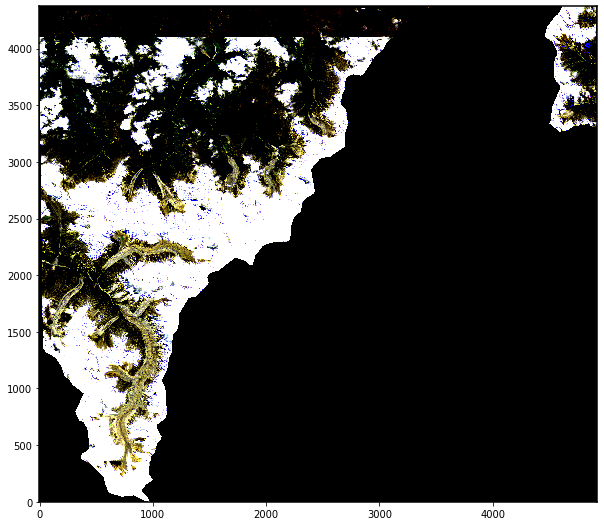

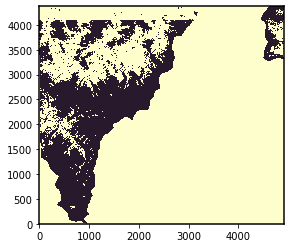

In [8]:
# Bands
# B1 Blue (.45-.52) Landsat | Sentinel B1 higher-res Ultra Blue (.443 central) or B2 (.49 central)
# B2 Green (.52-.60) | Sentinel B3 Green (.560)
# B3 Red (.63-.69) | Sentinel B4 Red (.665)
# B4 Near-IR (.77-.90) | Sentinel B5-B8a
# B5 Short-Wave IR (1.55-1.75) | B10 and B11
# B6 Thermal1 | ?
# B6 Thermal2 (10.40-12.50) | ? 
# B7 Mid-IR (2.08-2.35) | B12
# ["B1", "B2", "B3", "B4", "B5", "B6_VCID1", "B6_VCID2", "B7", "elevation", "slope"]

arr = tiff_np[:, :, [0, 2, 3, 6, 9, -1, -1, 11]]
arr = (arr - np.mean(arr)) / np.std(arr)


(4373, 4926, 8)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


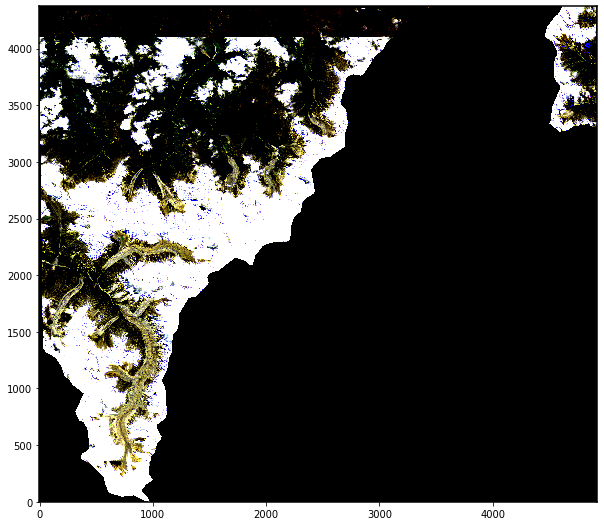

In [9]:
print(arr.shape)
plt.figure(figsize=(10, 10))
plt.imshow(arr[:, :, [2, 1, 0]])

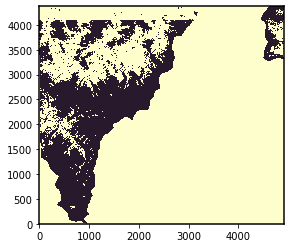

In [10]:
mask = np.sum(arr[:, :, :3], axis=2) < 0.01
plt.figure()
plt.imshow(mask)

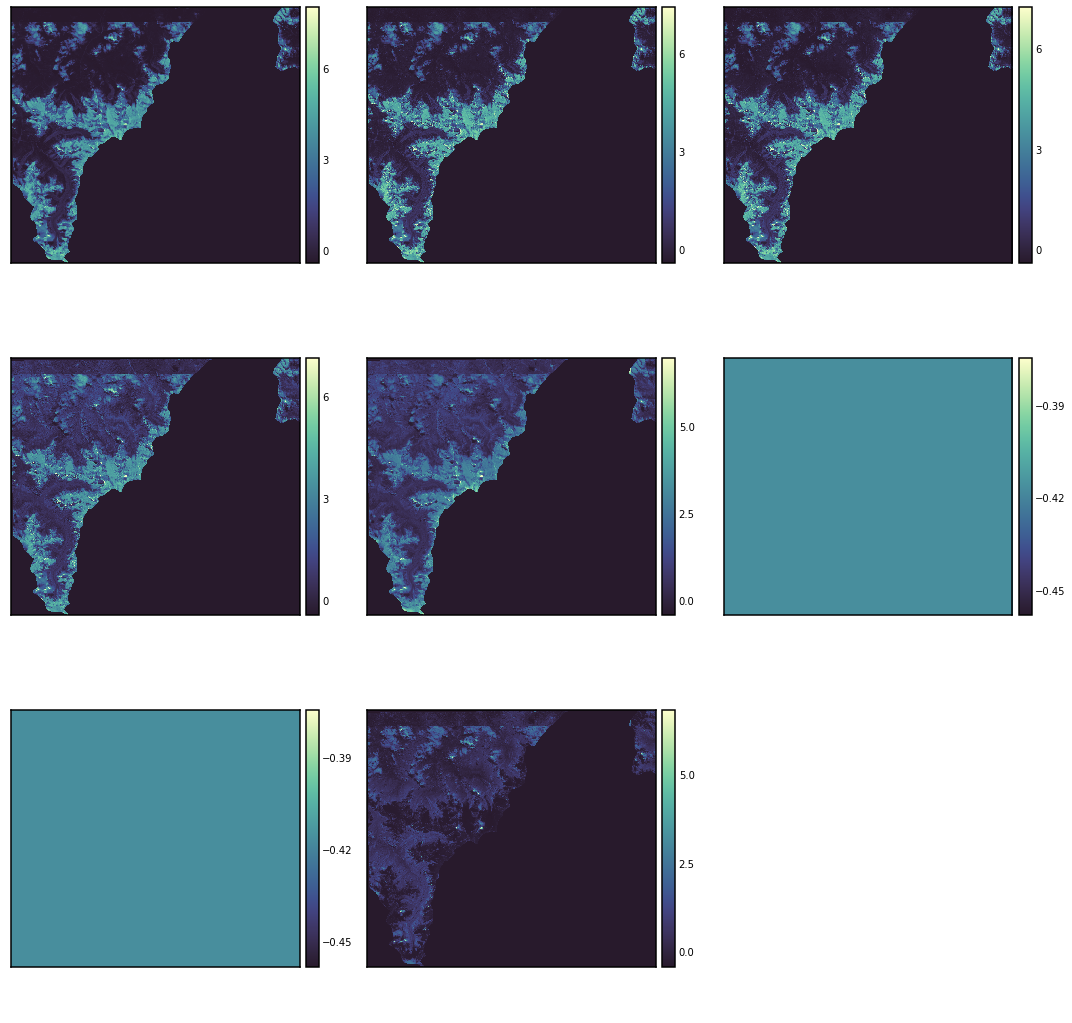

In [19]:
isns.ImageGrid(arr, height=5)

In [7]:
# all_tiff_fnames = list(tiff_path.glob('*.tif'))
# tiff_fname = tiff_path / all_tiff_fnames[1]
# dem_fname = dem_path / all_tiff_fnames[1]

# print(tiff_fname, df[df['Landsat ID'] == tiff_fname.name].iloc[0]['split'])

# assert tiff_fname.exists()
# assert dem_fname.exists()

# tiff_np = get_tiff_np(tiff_fname, dem_fname, physics_res=64, physics_scale=1, verbose=True)
# mask = np.sum(tiff_np[:, :, :3], axis=2) == 0
# tiff_np = tiff_np[:, :, use_channels]
# tiff_np = (tiff_np - _mean) / _std
# label_mask = get_mask(tiff_fname, labels)

# plt.figure(figsize=(10, 10))
# plt.imshow(tiff_np[:, :, [2, 1, 0]])

# y_true = np.zeros((label_mask.shape[0], label_mask.shape[1]))
# print(f'is_binary={is_binary}, binary_class={binary_class_idx}, label_mask={label_mask.shape}, y_true={y_true.shape}')

# if is_binary:
#     assert binary_class_idx != 0, 'You are trying to predict BG instead of CI or DCG'
#     y_true[label_mask[:, :, binary_class_idx-1] != 1] = 0
#     y_true[label_mask[:, :, binary_class_idx-1] == 1] = 1
# else:
#     for i in range(label_mask.shape[2]):
#         y_true[label_mask[:, :, i] == 1] = i + 1
# y_true = y_true.astype(np.uint8)
# y_true[mask] = 0
# print(y_true.shape, np.unique(y_true))
# plt.figure(figsize=(10, 10))
# plt.imshow(y_true)

In [13]:
with rasterio.Env():
    # Open TIFF file with rasterio
    src = read_tiff(tiff_fname)

    # You can use this to read the whole TIFF as an array if you want to create one with all the channels included
    # In this case we will only have the prediction channels
    # tiff_np = np.transpose(src.read(), (1, 2, 0)).astype(np.float32)
    # tiff_np = np.nan_to_num(tiff_np)
    profile = src.profile

    profile['dtype'] = str(y_pred.dtype)
    profile['height'] = y_pred.shape[0]
    profile['width'] = y_pred.shape[1]

    # assert profile['dtype'] in str(y_pred.dtype)
    # assert profile['height'] == y_pred.shape[0]
    # assert profile['width'] == y_pred.shape[1]

    # print(y_pred.shape, y_true.shape, tiff_np.shape)
    # print(y_pred.dtype, y_true.dtype, tiff_np.dtype)
    # st = np.dstack((tiff_np, y_pred, y_true))
    # print(st.shape)
    # st = np.moveaxis(st, [0, 1, 2], [2, 1, 0])
    # print(st.shape)

    # profile['dtype'] = 'float32'
    # profile['count'] = tiff_np.shape[2]+1
    profile['count'] = 1
    print(profile)
 
    # fname = f'{tiff_fname.stem}_pred_{conf.run_name}.tif'
    fname = 'image8_pred.tif'
    with rasterio.open(fname, 'w', **profile) as dst:
        # for i in range(tiff_np.shape[2]):
        #     dst.write(tiff_np[:, :, i], i+1)
        # dst.write(y_pred, i+1)
        # dst.write(y_true, i+2)
        dst.write(y_pred, 1)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 4926, 'height': 4373, 'count': 1, 'crs': CRS.from_epsg(32645), 'transform': Affine(10.0, 0.0, 364830.0,
       0.0, -10.0, 3141010.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'pixel'}
